FloatPairs avec LS

In [1]:
# Cellule 1: Import des bibliothèques
import random
import numpy as np
import time
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator import PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
import matplotlib.pyplot as plt

In [2]:
# Cellule 2: Implémentation du problème FloatPairsMax
class FloatPairsMax(Problem):
    """
    Problème FloatPairs: Maximiser le nombre de paires adjacentes de signes différents
    dans une séquence de nombres flottants.
    """
    def __init__(self, number_of_floats: int, min_value: float, max_value: float):
        super().__init__()
        self.number_of_floats = number_of_floats
        self.min_value = min_value
        self.max_value = max_value
        
        self.lower_bound = [self.min_value] * number_of_floats
        self.upper_bound = [self.max_value] * number_of_floats
        
        self.number_of_objectives = 1
        self.obj_directions = [self.MAXIMIZE]  # On maximise le nombre de paires
        self.obj_labels = ['PairsCount']
        
    def number_of_variables(self) -> int:
        return self.number_of_floats
    
    def number_of_objectives(self) -> int:
        return self.number_of_objectives
    
    def number_of_constraints(self) -> int:
        return 0
    
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        """
        Calcule le nombre de paires adjacentes de signes différents
        """
        variables = solution.variables
        pairs_count = 0
        
        # Parcours des paires adjacentes
        for i in range(len(variables) - 1):
            # Vérification si les signes sont différents
            # (attention au zéro : le zéro est considéré comme positif pour ce problème)
            if (variables[i] * variables[i + 1] < 0) or \
               (variables[i] == 0 and variables[i + 1] < 0) or \
               (variables[i + 1] == 0 and variables[i] < 0):
                pairs_count += 1
        
        solution.objectives[0] = pairs_count  # On maximise directement
        return solution
    
    def create_solution(self) -> FloatSolution:
        """
        Crée une solution aléatoire
        """
        new_solution = FloatSolution(
            self.lower_bound,
            self.upper_bound,
            self.number_of_objectives,
            self.number_of_constraints()
        )
        
        # Génération de nombres aléatoires dans l'intervalle
        new_solution.variables = [
            random.uniform(self.lower_bound[i], self.upper_bound[i])
            for i in range(self.number_of_variables())
        ]
        
        return new_solution
    
    def name(self) -> str:
        return 'FloatPairsMax'

In [3]:
# Cellule 3: Test manuel du problème FloatPairs
print("=== Test du problème FloatPairs ===")

# Configuration du problème (exemple du TP)
n = 8
bi = -10.00
bs = 10.00

problem = FloatPairsMax(number_of_floats=n, min_value=bi, max_value=bs)

# Test avec l'exemple du TP
example_solution = problem.create_solution()
example_solution.variables = [-10.00, 5.00, 6.25, 3.14, -8.7, -9.75, 1.36, -9.99]

example_solution = problem.evaluate(example_solution)
print(f"Solution d'exemple: {[f'{v:.2f}' for v in example_solution.variables]}")
print(f"Nombre de paires: {example_solution.objectives[0]}")

# Détail des paires
print("\nDétail des paires trouvées:")
for i in range(len(example_solution.variables) - 1):
    v1 = example_solution.variables[i]
    v2 = example_solution.variables[i + 1]
    if (v1 * v2 < 0) or (v1 == 0 and v2 < 0) or (v2 == 0 and v1 < 0):
        print(f"  Positions {i} et {i+1}: {v1:.2f} et {v2:.2f}")

# Test avec une solution optimale théorique
print("\n=== Test avec solution optimale théorique ===")
# Pour maximiser les paires, on alterne signes positif et négatif
optimal_solution = problem.create_solution()
optimal_sequence = []
for i in range(n):
    if i % 2 == 0:
        optimal_sequence.append(bs)  # Positif
    else:
        optimal_sequence.append(bi)  # Négatif

optimal_solution.variables = optimal_sequence
optimal_solution = problem.evaluate(optimal_solution)
print(f"Solution optimale théorique (alternance): {[f'{v:.2f}' for v in optimal_solution.variables]}")
print(f"Nombre de paires théorique max: {optimal_solution.objectives[0]}")
print(f"Théoriquement, pour n={n}, on peut avoir au maximum {n-1} paires.")

# Test avec une solution uniforme (tous de même signe)
uniform_solution = problem.create_solution()
uniform_solution.variables = [bs] * n  # Tous positifs
uniform_solution = problem.evaluate(uniform_solution)
print(f"\nSolution uniforme (tous positifs): {[f'{v:.2f}' for v in uniform_solution.variables]}")
print(f"Nombre de paires: {uniform_solution.objectives[0]}")

=== Test du problème FloatPairs ===
Solution d'exemple: ['-10.00', '5.00', '6.25', '3.14', '-8.70', '-9.75', '1.36', '-9.99']
Nombre de paires: 4

Détail des paires trouvées:
  Positions 0 et 1: -10.00 et 5.00
  Positions 3 et 4: 3.14 et -8.70
  Positions 5 et 6: -9.75 et 1.36
  Positions 6 et 7: 1.36 et -9.99

=== Test avec solution optimale théorique ===
Solution optimale théorique (alternance): ['10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00']
Nombre de paires théorique max: 7
Théoriquement, pour n=8, on peut avoir au maximum 7 paires.

Solution uniforme (tous positifs): ['10.00', '10.00', '10.00', '10.00', '10.00', '10.00', '10.00', '10.00']
Nombre de paires: 0


In [4]:
# Cellule 4: Fonction robuste de recherche locale pour FloatPairs
def run_local_search_floatpairs(problem, max_evaluations=10000, mutation_probability=0.1, 
                               mutation_perturbation=20.0, runs=20):
    """
    Exécute la recherche locale pour le problème FloatPairs
    """
    results = []
    execution_times = []
    best_solutions = []
    
    print(f"=== Recherche Locale pour FloatPairs ===")
    print(f"Configuration: {problem.number_of_variables()} variables, "
          f"intervalle [{problem.min_value}, {problem.max_value}]")
    print(f"Max paires théorique: {problem.number_of_variables() - 1}")
    print(f"Paramètres: max_evaluations={max_evaluations}, mutation_probability={mutation_probability}")
    
    for run in range(runs):
        start_time = time.time()
        
        # Configuration de la mutation polynomiale
        mutation = PolynomialMutation(
            probability=mutation_probability,
            distribution_index=mutation_perturbation
        )
        
        # Configuration de l'algorithme de recherche locale
        algorithm = LocalSearch(
            problem=problem,
            mutation=mutation,
            termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
        )
        
        # Exécution de l'algorithme
        algorithm.run()
        
        # Récupération du résultat (gestion des différentes versions JMetalPy)
        result = None
        if hasattr(algorithm, 'get_result') and callable(algorithm.get_result):
            result = algorithm.get_result()
        elif hasattr(algorithm, 'result'):
            result = algorithm.result
            if callable(result):
                result = result()
        else:
            print(f"Run {run+1}: Impossible de récupérer le résultat")
            continue
        
        end_time = time.time()
        execution_time = end_time - start_time
        
        if result is not None:
            # Stockage des résultats
            results.append(result.objectives[0])  # Nombre de paires
            execution_times.append(execution_time)
            best_solutions.append(result)
            
            print(f"Run {run+1}: Paires = {result.objectives[0]:.0f}/{problem.number_of_variables()-1}, "
                  f"Temps = {execution_time:.4f}s")
    
    return results, execution_times, best_solutions

In [5]:
# Cellule 5: Exécution de la recherche locale pour FloatPairs
# Configuration du problème (même que l'exemple)
n = 8
bi = -10.00
bs = 10.00

problem = FloatPairsMax(number_of_floats=n, min_value=bi, max_value=bs)

# Exécution de la recherche locale
print("Exécution de la recherche locale...")
results, exec_times, best_sols = run_local_search_floatpairs(
    problem=problem,
    max_evaluations=5000,
    mutation_probability=0.2,
    mutation_perturbation=20.0,
    runs=20
)

[2026-01-27 13:49:12,788] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:12,789] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:12,791] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:12,792] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:12,912] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:12,913] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:12,913] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:12,914] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:12,914] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Exécution de la recherche locale...
=== Recherche Locale pour FloatPairs ===
Configuration: 8 variables, intervalle [-10.0, 10.0]
Max paires théorique: 7
Paramètres: max_evaluations=5000, mutation_probability=0.2
Run 1: Paires = 1/7, Temps = 0.1246s


[2026-01-27 13:49:13,029] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,029] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,030] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,030] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,030] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:13,145] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,146] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,147] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,147] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,148] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 2: Paires = 0/7, Temps = 0.1165s
Run 3: Paires = 0/7, Temps = 0.1168s


[2026-01-27 13:49:13,263] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,264] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,265] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,265] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,265] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:13,379] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,380] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,380] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,381] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,381] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 4: Paires = 0/7, Temps = 0.1179s
Run 5: Paires = 0/7, Temps = 0.1156s


[2026-01-27 13:49:13,495] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,496] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,496] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,497] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,497] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:13,611] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,612] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,612] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,612] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,613] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 6: Paires = 0/7, Temps = 0.1162s
Run 7: Paires = 0/7, Temps = 0.1155s


[2026-01-27 13:49:13,726] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,727] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,728] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,728] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,729] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:13,843] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,844] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,844] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,845] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,845] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 8: Paires = 0/7, Temps = 0.1151s
Run 9: Paires = 0/7, Temps = 0.1169s


[2026-01-27 13:49:13,959] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:13,961] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:13,962] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:13,962] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:13,963] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:14,078] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,079] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,079] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,080] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,080] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 10: Paires = 0/7, Temps = 0.1171s
Run 11: Paires = 0/7, Temps = 0.1180s


[2026-01-27 13:49:14,194] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,195] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,195] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,196] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,196] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:14,310] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,311] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,311] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,312] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,313] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 12: Paires = 0/7, Temps = 0.1161s
Run 13: Paires = 0/7, Temps = 0.1157s


[2026-01-27 13:49:14,430] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,431] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,431] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,431] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,432] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:14,546] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,547] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,547] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,548] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,548] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 14: Paires = 0/7, Temps = 0.1199s
Run 15: Paires = 0/7, Temps = 0.1162s


[2026-01-27 13:49:14,665] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,665] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,666] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,666] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,667] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:14,781] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,781] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,782] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,782] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,782] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 16: Paires = 0/7, Temps = 0.1185s
Run 17: Paires = 0/7, Temps = 0.1159s


[2026-01-27 13:49:14,899] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:14,899] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:14,900] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:14,900] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:14,900] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:15,014] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:15,014] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:15,015] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:15,015] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:15,015] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 18: Paires = 1/7, Temps = 0.1178s
Run 19: Paires = 0/7, Temps = 0.1152s


[2026-01-27 13:49:15,130] [jmetal.core.algorithm] [DEBUG] Finished!


Run 20: Paires = 0/7, Temps = 0.1166s


In [6]:
# Cellule 6: Analyse statistique des résultats
print("\n=== Analyse statistique des résultats ===")

if results:
    # Calcul des statistiques
    mean_result = np.mean(results)
    median_result = np.median(results)
    std_result = np.std(results)
    min_result = np.min(results)
    max_result = np.max(results)
    
    mean_time = np.mean(exec_times)
    median_time = np.median(exec_times)
    std_time = np.std(exec_times)
    
    max_theoretical = n - 1
    
    print(f"Résultats (nombre de paires):")
    print(f"  Moyenne: {mean_result:.2f}")
    print(f"  Médiane: {median_result:.2f}")
    print(f"  Écart-type: {std_result:.2f}")
    print(f"  Minimum: {min_result:.0f}")
    print(f"  Maximum: {max_result:.0f}")
    print(f"  Maximum théorique: {max_theoretical}")
    
    print(f"\nTaux de succès (atteint le max théorique):")
    success_rate = sum([1 for r in results if r == max_theoretical]) / len(results) * 100
    print(f"  {success_rate:.1f}% des runs ont atteint le maximum théorique")
    
    print(f"\nTemps d'exécution:")
    print(f"  Moyenne: {mean_time:.4f} s")
    print(f"  Médiane: {median_time:.4f} s")
    print(f"  Écart-type: {std_time:.4f} s")
    
    # Affichage de la meilleure solution
    if best_sols:
        best_idx = np.argmax(results)
        best_solution = best_sols[best_idx]
        
        print(f"\n=== Meilleure solution trouvée (run {best_idx + 1}) ===")
        print(f"Nombre de paires: {best_solution.objectives[0]:.0f}")
        print(f"Variables: {[f'{v:.2f}' for v in best_solution.variables]}")
        
        # Analyse détaillée de la meilleure solution
        print(f"\nAnalyse détaillée des paires:")
        variables = best_solution.variables
        for i in range(len(variables) - 1):
            v1 = variables[i]
            v2 = variables[i + 1]
            has_pair = (v1 * v2 < 0) or (v1 == 0 and v2 < 0) or (v2 == 0 and v1 < 0)
            pair_type = "✓ PAIRE" if has_pair else "✗ même signe"
            print(f"  Positions {i} et {i+1}: {v1:7.2f} et {v2:7.2f} -> {pair_type}")
else:
    print("Aucun résultat disponible")


=== Analyse statistique des résultats ===
Résultats (nombre de paires):
  Moyenne: 0.10
  Médiane: 0.00
  Écart-type: 0.30
  Minimum: 0
  Maximum: 1
  Maximum théorique: 7

Taux de succès (atteint le max théorique):
  0.0% des runs ont atteint le maximum théorique

Temps d'exécution:
  Moyenne: 0.1171 s
  Médiane: 0.1166 s
  Écart-type: 0.0021 s

=== Meilleure solution trouvée (run 1) ===
Nombre de paires: 1
Variables: ['-0.13', '-3.60', '-0.47', '-2.38', '-4.72', '7.36', '5.31', '0.79']

Analyse détaillée des paires:
  Positions 0 et 1:   -0.13 et   -3.60 -> ✗ même signe
  Positions 1 et 2:   -3.60 et   -0.47 -> ✗ même signe
  Positions 2 et 3:   -0.47 et   -2.38 -> ✗ même signe
  Positions 3 et 4:   -2.38 et   -4.72 -> ✗ même signe
  Positions 4 et 5:   -4.72 et    7.36 -> ✓ PAIRE
  Positions 5 et 6:    7.36 et    5.31 -> ✗ même signe
  Positions 6 et 7:    5.31 et    0.79 -> ✗ même signe


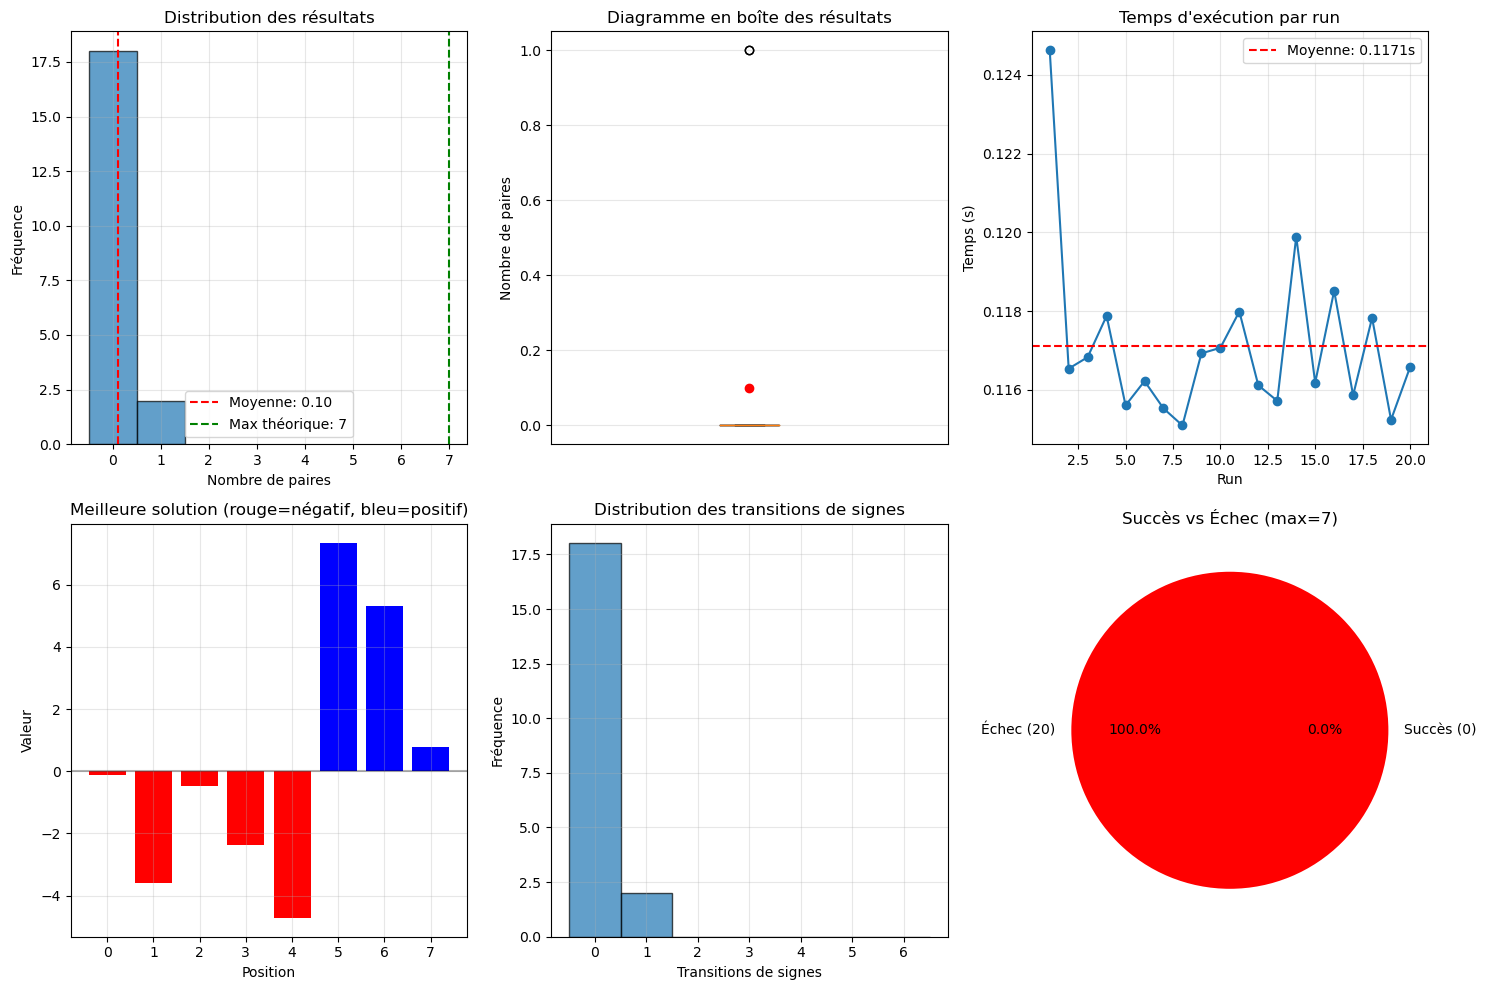

In [7]:
# Cellule 7: Visualisation des résultats
if results:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Histogramme des résultats
    axes[0, 0].hist(results, bins=range(int(min_result), int(max_result) + 2), 
                    edgecolor='black', alpha=0.7, align='left')
    axes[0, 0].axvline(mean_result, color='r', linestyle='--', label=f'Moyenne: {mean_result:.2f}')
    axes[0, 0].axvline(n-1, color='g', linestyle='--', label=f'Max théorique: {n-1}')
    axes[0, 0].set_xlabel('Nombre de paires')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].set_title('Distribution des résultats')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Diagramme en boîte
    axes[0, 1].boxplot(results)
    axes[0, 1].scatter([1], [mean_result], color='r', label='Moyenne', zorder=3)
    axes[0, 1].set_ylabel('Nombre de paires')
    axes[0, 1].set_title('Diagramme en boîte des résultats')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks([])
    
    # Temps d'exécution
    axes[0, 2].plot(range(1, len(exec_times) + 1), exec_times, marker='o', linestyle='-')
    axes[0, 2].axhline(mean_time, color='r', linestyle='--', label=f'Moyenne: {mean_time:.4f}s')
    axes[0, 2].set_xlabel('Run')
    axes[0, 2].set_ylabel('Temps (s)')
    axes[0, 2].set_title('Temps d\'exécution par run')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Évolution de la meilleure solution
    if best_sols:
        best_solution = best_sols[np.argmax(results)]
        axes[1, 0].bar(range(n), best_solution.variables, color=['red' if x < 0 else 'blue' for x in best_solution.variables])
        axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 0].set_xlabel('Position')
        axes[1, 0].set_ylabel('Valeur')
        axes[1, 0].set_title('Meilleure solution (rouge=négatif, bleu=positif)')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Analyse des signes
    if best_sols:
        signs = []
        for sol in best_sols[:5]:  # Premières 5 solutions
            sign_pattern = ''.join(['+' if x >= 0 else '-' for x in sol.variables])
            signs.append(sign_pattern)
        
        # Comptage des transitions de signes
        transition_counts = []
        for sol in best_sols:
            transitions = 0
            for i in range(n-1):
                if (sol.variables[i] >= 0) != (sol.variables[i+1] >= 0):
                    transitions += 1
            transition_counts.append(transitions)
        
        axes[1, 1].hist(transition_counts, bins=range(n), 
                       edgecolor='black', alpha=0.7, align='left')
        axes[1, 1].set_xlabel('Transitions de signes')
        axes[1, 1].set_ylabel('Fréquence')
        axes[1, 1].set_title('Distribution des transitions de signes')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Ratio succès/échec
    success_count = sum([1 for r in results if r == n-1])
    fail_count = len(results) - success_count
    axes[1, 2].pie([success_count, fail_count], 
                  labels=[f'Succès ({success_count})', f'Échec ({fail_count})'],
                  colors=['green', 'red'], autopct='%1.1f%%')
    axes[1, 2].set_title(f'Succès vs Échec (max={n-1})')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Cellule 8: Expérimentation avec différents paramètres
def experiment_floatpairs_params(n=8, bi=-10.0, bs=10.0, runs_per_config=10):
    """
    Expérimente différents paramètres pour FloatPairs
    """
    problem = FloatPairsMax(number_of_floats=n, min_value=bi, max_value=bs)
    
    # Paramètres à tester
    param_configs = [
        {'max_evaluations': 1000, 'mutation_probability': 0.05, 'mutation_perturbation': 10.0},
        {'max_evaluations': 1000, 'mutation_probability': 0.1, 'mutation_perturbation': 20.0},
        {'max_evaluations': 1000, 'mutation_probability': 0.2, 'mutation_perturbation': 20.0},
        {'max_evaluations': 5000, 'mutation_probability': 0.1, 'mutation_perturbation': 20.0},
        {'max_evaluations': 5000, 'mutation_probability': 0.3, 'mutation_perturbation': 30.0},
    ]
    
    results_summary = []
    
    print("=== Expérimentation avec différents paramètres ===")
    for i, config in enumerate(param_configs):
        print(f"\nConfiguration {i+1}:")
        print(f"  max_evaluations={config['max_evaluations']}")
        print(f"  mutation_probability={config['mutation_probability']}")
        print(f"  mutation_perturbation={config['mutation_perturbation']}")
        
        results, exec_times, _ = run_local_search_floatpairs(
            problem=problem,
            max_evaluations=config['max_evaluations'],
            mutation_probability=config['mutation_probability'],
            mutation_perturbation=config['mutation_perturbation'],
            runs=runs_per_config
        )
        
        if results:
            mean_result = np.mean(results)
            success_rate = sum([1 for r in results if r == n-1]) / len(results) * 100
            mean_time = np.mean(exec_times)
            
            results_summary.append({
                'config': config,
                'mean_result': mean_result,
                'success_rate': success_rate,
                'mean_time': mean_time
            })
            
            print(f"  Résultat moyen: {mean_result:.2f}")
            print(f"  Taux de succès: {success_rate:.1f}%")
            print(f"  Temps moyen: {mean_time:.4f}s")
    
    # Affichage du meilleur paramètre
    if results_summary:
        best_by_result = max(results_summary, key=lambda x: x['mean_result'])
        best_by_success = max(results_summary, key=lambda x: x['success_rate'])
        
        print("\n=== Synthèse ===")
        print("Meilleure configuration par résultat moyen:")
        print(f"  Paramètres: {best_by_result['config']}")
        print(f"  Résultat moyen: {best_by_result['mean_result']:.2f}")
        print(f"  Taux de succès: {best_by_result['success_rate']:.1f}%")
        
        print("\nMeilleure configuration par taux de succès:")
        print(f"  Paramètres: {best_by_success['config']}")
        print(f"  Résultat moyen: {best_by_success['mean_result']:.2f}")
        print(f"  Taux de succès: {best_by_success['success_rate']:.1f}%")
    
    return results_summary

# Exécution de l'expérimentation
summary = experiment_floatpairs_params(n=8, bi=-10.0, bs=10.0, runs_per_config=10)

[2026-01-27 13:49:15,855] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:15,856] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:15,856] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:15,857] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:15,883] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:15,883] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:15,883] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:15,884] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:15,884] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:15,906] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:15,907] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:15,907] [jm

=== Expérimentation avec différents paramètres ===

Configuration 1:
  max_evaluations=1000
  mutation_probability=0.05
  mutation_perturbation=10.0
=== Recherche Locale pour FloatPairs ===
Configuration: 8 variables, intervalle [-10.0, 10.0]
Max paires théorique: 7
Paramètres: max_evaluations=1000, mutation_probability=0.05
Run 1: Paires = 0/7, Temps = 0.0278s
Run 2: Paires = 0/7, Temps = 0.0237s
Run 3: Paires = 0/7, Temps = 0.0243s
Run 4: Paires = 1/7, Temps = 0.0247s
Run 5: Paires = 1/7, Temps = 0.0249s
Run 6: Paires = 0/7, Temps = 0.0240s
Run 7: Paires = 1/7, Temps = 0.0249s
Run 8: Paires = 1/7, Temps = 0.0238s


[2026-01-27 13:49:16,079] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,079] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,080] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,080] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:16,102] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,103] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,103] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,103] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,104] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:16,126] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,128] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,129] [jm

Run 9: Paires = 1/7, Temps = 0.0252s
Run 10: Paires = 0/7, Temps = 0.0238s
  Résultat moyen: 0.50
  Taux de succès: 0.0%
  Temps moyen: 0.0247s

Configuration 2:
  max_evaluations=1000
  mutation_probability=0.1
  mutation_perturbation=20.0
=== Recherche Locale pour FloatPairs ===
Configuration: 8 variables, intervalle [-10.0, 10.0]
Max paires théorique: 7
Paramètres: max_evaluations=1000, mutation_probability=0.1
Run 1: Paires = 1/7, Temps = 0.0251s
Run 2: Paires = 2/7, Temps = 0.0240s
Run 3: Paires = 2/7, Temps = 0.0243s
Run 4: Paires = 1/7, Temps = 0.0263s
Run 5: Paires = 2/7, Temps = 0.0259s
Run 6: Paires = 1/7, Temps = 0.0241s
Run 7: Paires = 0/7, Temps = 0.0257s


[2026-01-27 13:49:16,279] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,279] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:16,302] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,303] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,303] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,303] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,304] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:16,327] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,328] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,328] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,329] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,329] [jmetal.core.al

Run 8: Paires = 2/7, Temps = 0.0243s
Run 9: Paires = 1/7, Temps = 0.0252s
Run 10: Paires = 3/7, Temps = 0.0243s
  Résultat moyen: 1.50
  Taux de succès: 0.0%
  Temps moyen: 0.0249s

Configuration 3:
  max_evaluations=1000
  mutation_probability=0.2
  mutation_perturbation=20.0
=== Recherche Locale pour FloatPairs ===
Configuration: 8 variables, intervalle [-10.0, 10.0]
Max paires théorique: 7
Paramètres: max_evaluations=1000, mutation_probability=0.2
Run 1: Paires = 1/7, Temps = 0.0272s
Run 2: Paires = 3/7, Temps = 0.0254s
Run 3: Paires = 1/7, Temps = 0.0259s
Run 4: Paires = 1/7, Temps = 0.0259s
Run 5: Paires = 1/7, Temps = 0.0261s


[2026-01-27 13:49:16,509] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,509] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,510] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,511] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:16,536] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,536] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,537] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,537] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,537] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:16,562] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,562] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,563] [jm

Run 6: Paires = 0/7, Temps = 0.0256s
Run 7: Paires = 2/7, Temps = 0.0276s
Run 8: Paires = 1/7, Temps = 0.0258s
Run 9: Paires = 2/7, Temps = 0.0255s
Run 10: Paires = 0/7, Temps = 0.0265s
  Résultat moyen: 1.20
  Taux de succès: 0.0%
  Temps moyen: 0.0261s

Configuration 4:
  max_evaluations=5000
  mutation_probability=0.1
  mutation_perturbation=20.0
=== Recherche Locale pour FloatPairs ===
Configuration: 8 variables, intervalle [-10.0, 10.0]
Max paires théorique: 7
Paramètres: max_evaluations=5000, mutation_probability=0.1


[2026-01-27 13:49:16,728] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,729] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,729] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,730] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,730] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:16,842] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,843] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,843] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,844] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,844] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 1: Paires = 1/7, Temps = 0.1145s
Run 2: Paires = 0/7, Temps = 0.1142s


[2026-01-27 13:49:16,964] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:16,964] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:16,965] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:16,965] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:16,965] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:17,075] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,075] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,076] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,076] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,076] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 3: Paires = 0/7, Temps = 0.1213s
Run 4: Paires = 1/7, Temps = 0.1108s


[2026-01-27 13:49:17,184] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,185] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,185] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,185] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,186] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:17,303] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,308] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,308] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,309] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,309] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 5: Paires = 0/7, Temps = 0.1095s
Run 6: Paires = 1/7, Temps = 0.1228s


[2026-01-27 13:49:17,434] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,434] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,435] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,435] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,436] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:17,546] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,546] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,547] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,547] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,548] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 7: Paires = 0/7, Temps = 0.1268s
Run 8: Paires = 0/7, Temps = 0.1120s


[2026-01-27 13:49:17,665] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,665] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,665] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,666] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,666] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:17,782] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,782] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,783] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,783] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,783] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 9: Paires = 1/7, Temps = 0.1186s
Run 10: Paires = 0/7, Temps = 0.1171s
  Résultat moyen: 0.40
  Taux de succès: 0.0%
  Temps moyen: 0.1168s

Configuration 5:
  max_evaluations=5000
  mutation_probability=0.3
  mutation_perturbation=30.0
=== Recherche Locale pour FloatPairs ===
Configuration: 8 variables, intervalle [-10.0, 10.0]
Max paires théorique: 7
Paramètres: max_evaluations=5000, mutation_probability=0.3


[2026-01-27 13:49:17,902] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:17,902] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:17,903] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:17,903] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:17,903] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:18,032] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,034] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,034] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,034] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,035] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 1: Paires = 1/7, Temps = 0.1199s
Run 2: Paires = 1/7, Temps = 0.1314s


[2026-01-27 13:49:18,174] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,175] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,175] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,176] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,177] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:18,297] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,298] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,298] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,298] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,299] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 3: Paires = 1/7, Temps = 0.1407s
Run 4: Paires = 1/7, Temps = 0.1232s


[2026-01-27 13:49:18,427] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,428] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,428] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,429] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,429] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:18,549] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,549] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,550] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,550] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,550] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 5: Paires = 1/7, Temps = 0.1298s
Run 6: Paires = 0/7, Temps = 0.1218s


[2026-01-27 13:49:18,669] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,670] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,670] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,670] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,671] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:18,796] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,796] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,797] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,797] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,797] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Run 7: Paires = 1/7, Temps = 0.1203s
Run 8: Paires = 0/7, Temps = 0.1265s


[2026-01-27 13:49:18,921] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-01-27 13:49:18,921] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-27 13:49:18,921] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-01-27 13:49:18,922] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-27 13:49:18,922] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-01-27 13:49:19,040] [jmetal.core.algorithm] [DEBUG] Finished!


Run 9: Paires = 0/7, Temps = 0.1247s
Run 10: Paires = 1/7, Temps = 0.1192s
  Résultat moyen: 0.70
  Taux de succès: 0.0%
  Temps moyen: 0.1258s

=== Synthèse ===
Meilleure configuration par résultat moyen:
  Paramètres: {'max_evaluations': 1000, 'mutation_probability': 0.1, 'mutation_perturbation': 20.0}
  Résultat moyen: 1.50
  Taux de succès: 0.0%

Meilleure configuration par taux de succès:
  Paramètres: {'max_evaluations': 1000, 'mutation_probability': 0.05, 'mutation_perturbation': 10.0}
  Résultat moyen: 0.50
  Taux de succès: 0.0%
